## Load Data

In [7]:
"""Load Data
Structure:
    1. Imports, Variables, Functions
    2. Load Data
"""

# 1. Imports, Variables, Functions
# imports
import pandas as pd, numpy as np, os, sys
import anndata as ad
import logging
from typing import *
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

logging.basicConfig(level=logging.INFO)

# variables
run_dir = os.path.join("..", "outputs", "run-24-09-24-02")
output_dir = os.path.join(run_dir, "outputs")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# functions


def load_run_output(input_dir: str) -> tuple:
    """Load the output of a run
    Args:
        input_dir (str): path to the run output directory
    Returns:
        loaded_variables (tuple): tuple of loaded variables
    """

    variables_to_load = [
        "predictions_test",
        "labels_test",
        "results_test",
        "all_outputs_test",
        "predictions_train",
        "labels_train",
        "results_train",
        "all_outputs_train",
        "adata_train",
        "adata_test",
        "id2type",
    ]

    # initialize loaded variables as an empty tuple
    loaded_variables = ()

    # loop through variables
    for variable in variables_to_load:
        if variable.startswith("adata"):
            loaded_variable = ad.read_h5ad(os.path.join(input_dir, f"{variable}.h5ad"))
        else:
            with open(os.path.join(input_dir, f"{variable}.pkl"), "rb") as f:
                loaded_variable = pickle.load(f)

        # add the loaded variable to the tuple
        loaded_variables += (loaded_variable,)

    print(f"Nº of loaded variables {len(loaded_variables)}")

    return loaded_variables


# 2. Load Data
(
    predictions_test,
    labels_test,
    results_test,
    all_outputs_test,
    predictions_train,
    labels_train,
    results_train,
    all_outputs_train,
    adata_train,
    adata_test,
    id2type,
) = load_run_output(run_dir)

Nº of loaded variables 11


In [10]:
# Results Table!
results_test.update({"Type": "Test"})
results_train.update({"Type": "Train"})

pd.DataFrame([results_test, results_train])

,test/accuracy,test/precision,test/recall,test/macro_f1,Type
0,0.451128,0.324297,0.451948,0.357895,Test
1,0.938980,0.906158,0.905692,0.905634,Train


# scGPT Plots

133 133


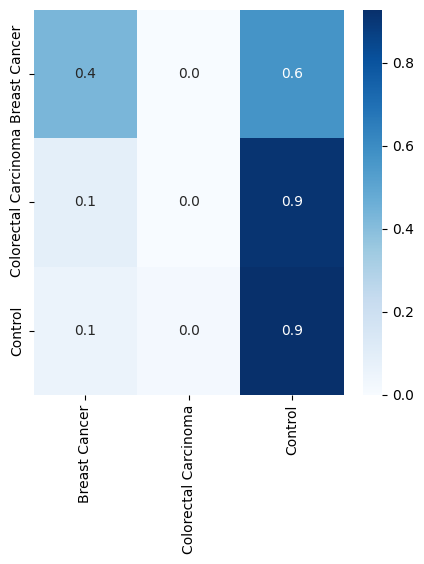

In [11]:
data_type = "test"

if data_type == "test":
    predictions = predictions_test
    celltypes = adata_test.obs["celltype"].values
    labels = labels_test
elif data_type == "train":
    predictions = predictions_train
    celltypes = adata_train.obs["celltype"].values
    labels = labels_train



celltypes = list(celltypes)
for i in set([id2type[p] for p in predictions]):
    if i not in celltypes:
        celltypes.remove(i)

print(len(labels), len(predictions))

cm = confusion_matrix(labels, predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# sorted celltypes by the order of the confusion matrix
sorted_celltypes = list()
for i in sorted(list(set(labels))):
    sorted_celltypes.append(id2type[i])

cm = pd.DataFrame(
    cm, index=sorted_celltypes[: cm.shape[0]], columns=sorted_celltypes[: cm.shape[1]]
)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")
plt.savefig(os.path.join(output_dir, f"{data_type}.confusion_matrix.png"), dpi=300)


In [15]:
results_test

{'test/accuracy': 0.5559050614812696,
 'test/precision': 0.5970607336825092,
 'test/recall': 0.44394765612660986,
 'test/macro_f1': 0.4814665465662321,
 'Type': 'Test'}

In [16]:
results_test

{'test/accuracy': 0.5559050614812696,
 'test/precision': 0.5970607336825092,
 'test/recall': 0.44394765612660986,
 'test/macro_f1': 0.4814665465662321,
 'Type': 'Test'}

In [17]:
results_train

{'test/accuracy': 0.6649640287769785,
 'test/precision': 0.7657982637818834,
 'test/recall': 0.5505639065956947,
 'test/macro_f1': 0.6067897529627032,
 'Type': 'Train'}

In [18]:
adata_test.obs["disease"].value_counts()

disease
Control                1418
Ulcerative Colitis      880
Crohn's Disease         527
Breast Cancer           354
Psoriasis               259
Lung Cancer              43
Lung Adenocarcinoma      16
Name: count, dtype: int64

In [19]:
adata_train.obs["disease"].value_counts()

disease
Control                5282
Ulcerative Colitis     2330
Crohn's Disease        2111
Breast Cancer          1495
Lung Adenocarcinoma    1384
Psoriasis              1037
Lung Cancer             261
Name: count, dtype: int64

In [20]:
from typing import *


def merge_embeddings(output: List[Dict]) -> np.array:
    """Merge Embeddings
    Args:
        output (List[Dict]): List of dictionaries with embeddings
    Returns:
        np.array: Merged embeddings
    """
    for i in range(len(output)):
        embeddings_i = output[i]["cell_emb"].numpy()

        if i == 0:
            embeddings = embeddings_i
        else:
            embeddings = np.concatenate((embeddings, embeddings_i), axis=0)
    return embeddings


scgpt_emb_test = merge_embeddings(all_outputs_test)
logging.info(f"SCGPT Embeddings Test Shape: {scgpt_emb_test.shape}")

scgpt_emb_train = merge_embeddings(all_outputs_train)
logging.info(f"SCGPT Embeddings Train Shape: {scgpt_emb_train.shape}")

INFO:root:SCGPT Embeddings Test Shape: (3497, 512)


INFO:root:SCGPT Embeddings Train Shape: (13900, 512)


In [21]:
results_test

{'test/accuracy': 0.5559050614812696,
 'test/precision': 0.5970607336825092,
 'test/recall': 0.44394765612660986,
 'test/macro_f1': 0.4814665465662321,
 'Type': 'Test'}

In [22]:
np.isnan(adata_test.X[100]).sum()

713

In [23]:
diseases_of_interest_set = adata_test.obs["disease_study"].unique()

d_data = dict()
d_data["n_diseases"] = dict()
d_data["n_controls"] = dict()
d_data["n_datasets"] = dict()
d_data["n_genes"] = dict()
d_data["n_de_signatures"] = dict()


for disease in diseases_of_interest_set:
    # Nº Disease Samples
    states = adata_test.obs.query(f'disease_study == "{disease}"')["celltype"].to_list()
    n_diseases = len(states) - states.count("Control")
    logging.info(f"{disease} Nº of Diseases: {n_diseases}")

    # Nº of Control Samples
    n_controls = states.count("Control")
    logging.info(f"{disease} Nº Controls: {n_controls}")

    # Nº of Datasets
    datasets = adata_test.obs.query(f'disease_study == "{disease}"')[
        "dataset"
    ].to_list()
    n_datasets = len(set(datasets))
    logging.info(f"{disease} Nº of Datasets: {len(datasets)}")

    # Nº of Genes
    n_genes = adata_test.obs.query(f'disease_study == "{disease}"')["n_genes"].to_list()
    logging.info(
        f"{disease} Nº of Genes: {np.mean(n_genes):.0f} ± {np.std(n_genes):.0f}"
    )

    # Nº of DE signatures
    all_ids = adata_test.obs.query(f'disease_study == "{disease}"')["ids"].to_list()

    de_signatures = list(set([id.split(";")[0] for id in all_ids]))
    n_de_signatures = len(de_signatures)
    logging.info(f"{disease} Nº of DE Signatures: {n_de_signatures}")

    # append to dictionary
    d_data["n_diseases"][disease] = n_diseases
    d_data["n_controls"][disease] = n_controls
    d_data["n_datasets"][disease] = len(datasets)
    d_data["n_genes"][disease] = n_genes
    d_data["n_de_signatures"][disease] = n_de_signatures

INFO:root:Psoriasis Nº of Diseases: 259
INFO:root:Psoriasis Nº Controls: 201
INFO:root:Psoriasis Nº of Datasets: 460
INFO:root:Psoriasis Nº of Genes: 17865 ± 2309
INFO:root:Psoriasis Nº of DE Signatures: 27
INFO:root:Crohn's Disease Nº of Diseases: 527
INFO:root:Crohn's Disease Nº Controls: 528
INFO:root:Crohn's Disease Nº of Datasets: 1055
INFO:root:Crohn's Disease Nº of Genes: 18853 ± 1850
INFO:root:Crohn's Disease Nº of DE Signatures: 14
INFO:root:Breast Cancer Nº of Diseases: 354
INFO:root:Breast Cancer Nº Controls: 106
INFO:root:Breast Cancer Nº of Datasets: 460
INFO:root:Breast Cancer Nº of Genes: 15495 ± 1984
INFO:root:Breast Cancer Nº of DE Signatures: 15
INFO:root:Ulcerative Colitis Nº of Diseases: 880
INFO:root:Ulcerative Colitis Nº Controls: 465
INFO:root:Ulcerative Colitis Nº of Datasets: 1345
INFO:root:Ulcerative Colitis Nº of Genes: 19259 ± 1234
INFO:root:Ulcerative Colitis Nº of DE Signatures: 3
INFO:root:Lung Cancer Nº of Diseases: 43
INFO:root:Lung Cancer Nº Controls: 

In [221]:
import seaborn as sns
from matplotlib import pyplot as plt

irb_colors = [
    "#ffd81cff",
    "#f6972dff",
    "#f2612dff",
    "#574270ff",
    "#00589bff",
    "#002f58ff",
]

labels = list(d_data["n_diseases"].keys())
n_controls = [d_data["n_controls"][x] for x in labels]
n_diseases = [d_data["n_diseases"][x] for x in labels]

df_plot = pd.DataFrame(
    {
        "Disease": labels,
        "Nº of Diseases": n_diseases,
        "Nº of Controls": n_controls,
    }
)

# Transform the DataFrame to long format
df_long = df_plot.melt(id_vars="Disease", var_name="Category", value_name="Count")

# Plotting with seaborn
plt.figure(figsize=(5, 4))
sns.barplot(
    data=df_long,
    x="Disease",
    y="Count",
    hue="Category",
    palette=[irb_colors[2], irb_colors[0]],
)

# Adding labels and title
plt.xlabel("", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of GEx Samples by Disease", fontsize=14)
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "n_samples.png"), dpi=300, bbox_inches="tight")

/tmp/ipykernel_32912/3272457251.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_32912/3272457251.py:20: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(


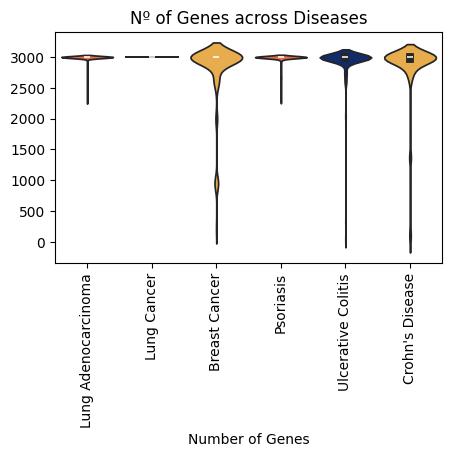

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming d_data is defined and contains the necessary data
# labels = list(d_data["n_diseases"].keys())
# n_genes = [d_data["n_genes"][x] for x in labels]

labels = adata_train.obs["disease_study"].to_list()
n_genes = (~np.isnan(adata_train.X)).sum(axis=1)

flat_genes = []
flat_labels = []
# for label, genes_list in zip(labels, n_genes):
#     flat_genes.extend(genes_list)
#     flat_labels.extend([label] * len(genes_list))

plt.figure(figsize=(5, 3))

# Violin plot
sns.violinplot(
    x=labels, y=n_genes, palette=[irb_colors[2], irb_colors[4], irb_colors[0]]
)

# Adding titles and labels
plt.xlabel("Number of Genes")
plt.ylabel("")
plt.xticks(rotation=90)
plt.title("Nº of Genes across Diseases")
plt.savefig(os.path.join(output_dir, "n_genes.png"), dpi=300, bbox_inches="tight")

array([2999, 2999, 2999, ..., 2999, 2999, 2999])

## Explore Embeddings

In [194]:
"""Explore Embeddings

Structure:
    1. Imports, Variables, Functions
    2. PCA Plots
    3. UMAP Plots
    4. Cosine Distance
    5. Pearson Correlation
    6. Euclidean Distance
"""

# 1. Imports, Variables, Functions
# imports
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# variables

irb_colors = [
    "#ffd81cff",
    "#f6972dff",
    "#f2612dff",
    "#574270ff",
    "#00589bff",
    "#002f58ff",
]

irb_colors = ["#ffb234", "#ff958e", "#ff6028", "#2779ff", "#022778"]


# functions
def plot_metrics(values, labels, metric, title=None, output_txt="", save=False):

    assert metric in [
        "Cosine Similarity",
        "Euclidean Distance",
        "Pearson Correlation",
    ], "Invalid metric"

    min_val = min([x for sublist in values for x in sublist])
    max_val = max([x for sublist in values for x in sublist])

    # change min max values
    if metric == "Cosine Similarity":
        min_val = 0
        max_val = 2
    elif metric == "Pearson Correlation":
        min_val = -1
        max_val = 1

    # Get a color map
    cmap = plt.get_cmap("hsv")

    # Define unique colors
    colors = [cmap(i / len(labels)) for i in range(len(labels))]

    # Define bin range
    bin_range = np.arange(min_val, max_val + 0.01, (max_val - min_val) / 20)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(4, 4))

    for i, (v, l) in enumerate(zip(values, labels)):

        # Plot control vs control
        density, bins = np.histogram(
            v, bins=bin_range, density=True
        )  # Calculate the density
        bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Calculate the center of each bin
        ax.plot(
            bin_centers, density, "-", color=colors[i], label=l
        )  # Create the density plot

        # Fill area under the curve
        ax.fill_between(bin_centers, density, color=colors[i], alpha=0.1)

    # Set y-axis limit
    ax.set_ylim(0, np.max(density) * 1.1)

    # Set x-axis limit
    ax.set_xlim(min_val, max_val)

    # Add labels and title
    ax.set_xlabel(f"{metric}")
    ax.set_ylabel("Density")

    if title:
        ax.set_title(f"{title}\nPairwise {metric} Distributions")
    else:
        ax.set_title(f"Pairwise {metric} Distributions")

    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Show grid
    ax.grid(True)

    # Show plot
    if save:
        plt.savefig(
            os.path.join(
                output_dir,
                f"pairwise_{metric.lower().replace(' ', '_')}.scgpt.{output_txt}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )


def get_pairwise_similarities(matrix, indexes_1, indexes_2=None):

    pairs = list()
    if indexes_2 is not None:

        for i in indexes_1:
            for j in indexes_2:
                pairs.append([i, j])

        pairs = np.array(pairs)
        return matrix[pairs[:, 0], pairs[:, 1]]

    else:
        for n, i in enumerate(indexes_1):
            for j in indexes_1[n + 1 :]:
                pairs.append([i, j])

        pairs = np.array(pairs)
        return matrix[pairs[:, 0], pairs[:, 1]]

### 2. UMAP Plots

In [66]:
import matplotlib.pyplot as plt
import umap
from mpl_toolkits.mplot3d import Axes3D

# Perform UMAP with 3 components
umap_model = umap.UMAP(n_components=3)
umap_embeddings_test = umap_model.fit_transform(scgpt_emb_test)
umap_embeddings_train = umap_model.fit_transform(scgpt_emb_train)

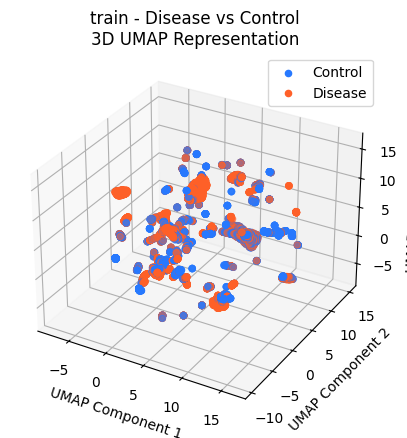

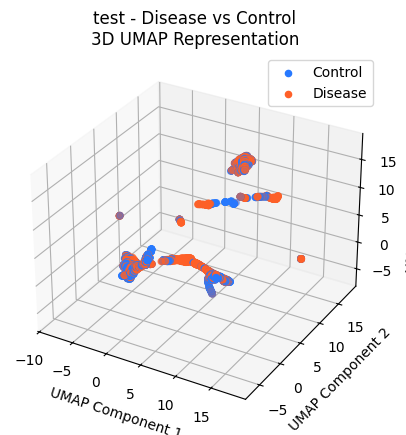

In [68]:
for data_type in ["train", "test"]:
    if data_type == "train":
        adata = adata_train
        embeddings = umap_embeddings_train
    else:
        adata = adata_test
        embeddings = umap_embeddings_test

    labels = [
        "Disease" if c != "Control" else "Control"
        for c in adata.obs["celltype"].to_list()
    ]

    # Map labels to colors
    label_color_map = {"Control": irb_colors[3], "Disease": irb_colors[2]}
    colors = [label_color_map.get(label, "grey") for label in labels]

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Scatter plot with colors
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors)

    # Adding legend
    for label in label_color_map:
        ax.scatter([], [], [], c=label_color_map[label], label=label)
    ax.legend()

    # Set labels
    ax.set_xlabel("UMAP Component 1")
    ax.set_ylabel("UMAP Component 2")
    ax.set_zlabel("UMAP Component 3")
    ax.set_title(f"{data_type} - Disease vs Control\n3D UMAP Representation")

    # Display the plot
    plt.savefig(
        os.path.join(output_dir, f"{data_type}.umap_3d.disease_control.png"),
        dpi=300,
        bbox_inches="tight",
    )

/tmp/ipykernel_32912/896277990.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(
/tmp/ipykernel_32912/896277990.py:53: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=label_color_map[label], label=label)


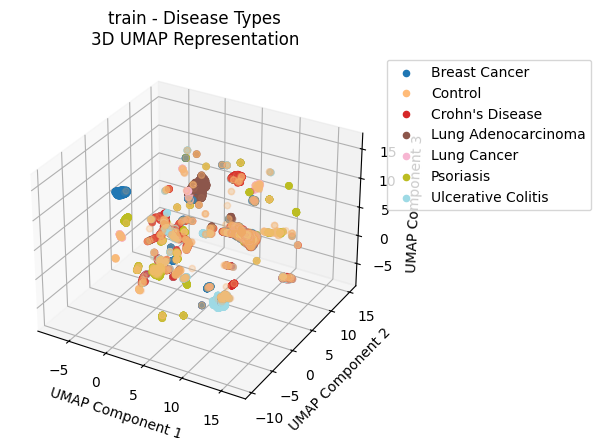

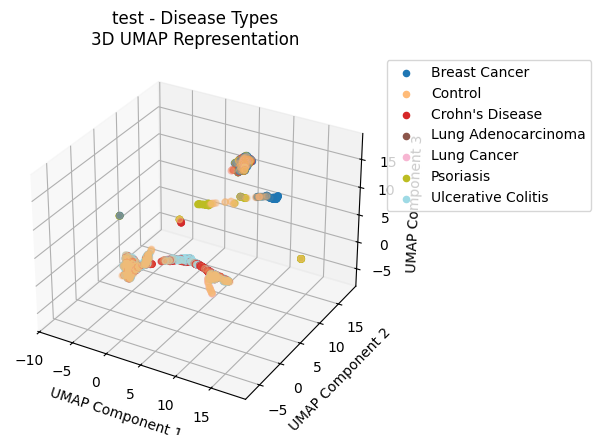

In [106]:
for data_type in ["train", "test"]:
    if data_type == "train":
        adata = adata_train
        embeddings = umap_embeddings_train
    else:
        adata = adata_test
        embeddings = umap_embeddings_test

    labels = adata.obs["celltype"].to_list()
    unique_labels = list(set(labels))
    unique_labels.sort()

    # Generate a color map using matplotlib
    colormap = plt.cm.get_cmap(
        "tab20", len(unique_labels)
    )  # You can change "viridis" to any other colormap

    # Map each label to a color
    label_color_map = {label: colormap(i) for i, label in enumerate(unique_labels)}

    # label_color_map.update({"Control": "grey"})

    colors = np.array([label_color_map[label] for label in labels])

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Scatter plot with colors
    c_idxs = [i for i, label in enumerate(labels) if label == "Control"]
    d_idxs = [i for i, label in enumerate(labels) if label != "Control"]

    # Plot the disease points first
    ax.scatter(
        embeddings[d_idxs, 0],
        embeddings[d_idxs, 1],
        embeddings[d_idxs, 2],
        c=colors[d_idxs],
    )

    # Then plot the control points (which will appear on top)
    ax.scatter(
        embeddings[c_idxs, 0],
        embeddings[c_idxs, 1],
        embeddings[c_idxs, 2],
        c=colors[c_idxs],
        alpha=0.06,
    )

    # Adding legend
    for label in label_color_map:

        ax.scatter([], [], [], c=label_color_map[label], label=label)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Set labels
    ax.set_xlabel("UMAP Component 1")
    ax.set_ylabel("UMAP Component 2")
    ax.set_zlabel("UMAP Component 3")
    ax.set_title(f"{data_type} - Disease Types\n3D UMAP Representation")

    # Display the plot
    plt.savefig(
        os.path.join(output_dir, f"{data_type}.umap_3d.diseases.png"),
        dpi=300,
        bbox_inches="tight",
    )

/tmp/ipykernel_32912/1299077925.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=label_color_map[label], label=label)


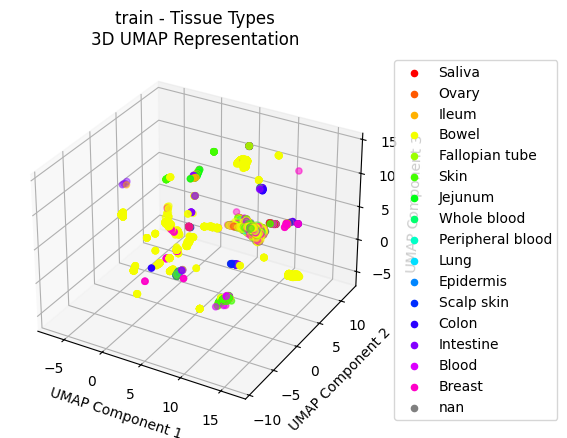

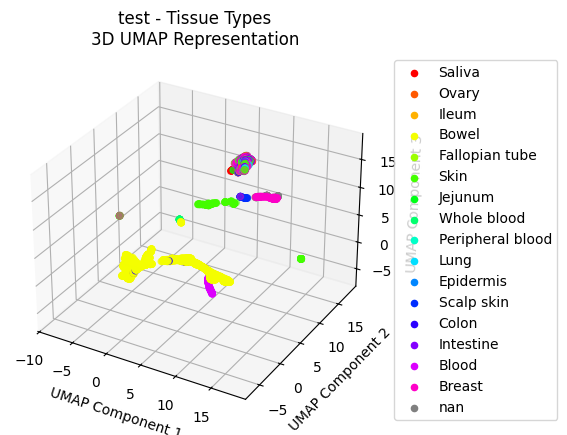

In [119]:
for data_type in ["train", "test"]:
    if data_type == "train":
        adata = adata_train
        embeddings = umap_embeddings_train
    else:
        adata = adata_test
        embeddings = umap_embeddings_test

    labels = adata.obs["celltype"].to_list()
    unique_labels = list(set(labels))
    unique_labels.sort()

    labels = adata_test.obs["tissue"].to_list()

    unique_labels = list(set(labels))

    # Get a color map
    cmap = plt.get_cmap("hsv")

    # Generate a unique color for each unique label
    colors = [cmap(i / len(unique_labels)) for i in range(len(unique_labels))]

    # Create a mapping from unique labels to colors
    label_color_map = {
        label: color
        for label, color in zip(unique_labels, colors)
        if str(label) != "nan"
    }
    label_color_map.update({"nan": (0.5, 0.5, 0.5, 1.0)})

    # Map the labels to their corresponding colors
    assigned_colors = list()
    for label in labels:
        assigned_colors.append(label_color_map[label])
    assigned_colors = np.array(assigned_colors)

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Scatter plot with colors
    nan_idxs = [i for i, label in enumerate(labels) if str(label) == "nan"]
    t_idxs = [i for i, label in enumerate(labels) if str(label) != "nan"]

    ax.scatter(
        embeddings[t_idxs, 0],
        embeddings[t_idxs, 1],
        embeddings[t_idxs, 2],
        c=assigned_colors[t_idxs],
    )

    ax.scatter(
        embeddings[nan_idxs, 0],
        embeddings[nan_idxs, 1],
        embeddings[nan_idxs, 2],
        c=assigned_colors[nan_idxs],
        alpha=1,
    )

    # Adding legend
    for label in label_color_map:
        ax.scatter([], [], [], c=label_color_map[label], label=label)
    ax.legend(loc="upper right", bbox_to_anchor=(1.5, 1))

    # Set labels
    ax.set_xlabel("UMAP Component 1")
    ax.set_ylabel("UMAP Component 2")
    ax.set_zlabel("UMAP Component 3")
    ax.set_title(f"{data_type} - Tissue Types\n3D UMAP Representation")

    # Display the plot
    plt.savefig(
        os.path.join(output_dir, f"{data_type}.umap_3d.tissue_types.png"),
        dpi=300,
        bbox_inches="tight",
    )

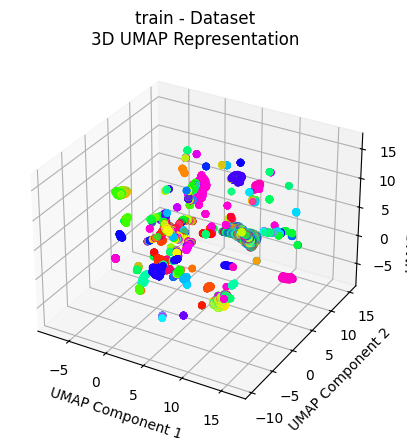

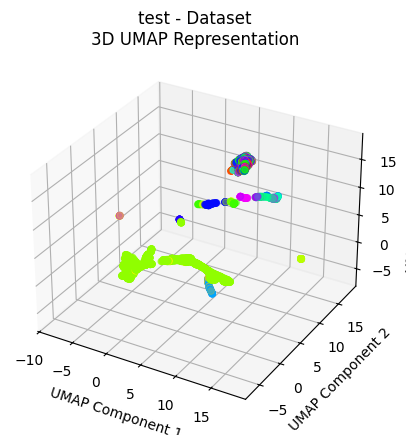

In [120]:
for data_type in ["train", "test"]:
    if data_type == "train":
        adata = adata_train
        embeddings = umap_embeddings_train
    else:
        adata = adata_test
        embeddings = umap_embeddings_test

    labels = adata.obs["dataset"].to_list()

    unique_labels = list(set(labels))

    # Get a color map
    cmap = plt.get_cmap("hsv")

    # Generate a unique color for each unique label
    colors = [cmap(i / len(unique_labels)) for i in range(len(unique_labels))]

    # Create a mapping from unique labels to colors
    label_color_map = {
        label: color
        for label, color in zip(unique_labels, colors)
        if str(label) != "nan"
    }
    label_color_map.update({"nan": (0.5, 0.5, 0.5, 1.0)})

    # Map the labels to their corresponding colors
    assigned_colors = list()
    for label in labels:
        assigned_colors.append(label_color_map[label])

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Scatter plot with colors
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=assigned_colors)

    # Adding legend
    # for label in label_color_map:
    #     ax.scatter([], [], [], c=label_color_map[label], label=label)
    # ax.legend(loc="upper right", bbox_to_anchor=(1.5, 1))

    # Set labels
    ax.set_xlabel("UMAP Component 1")
    ax.set_ylabel("UMAP Component 2")
    ax.set_zlabel("UMAP Component 3")
    ax.set_title(f"{data_type} - Dataset\n3D UMAP Representation")

    # Display the plot
    plt.savefig(
        os.path.join(output_dir, f"{data_type}.umap_3d.dataset.png"),
        dpi=300,
        bbox_inches="tight",
    )

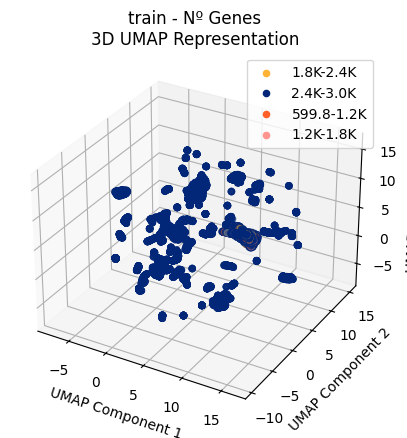

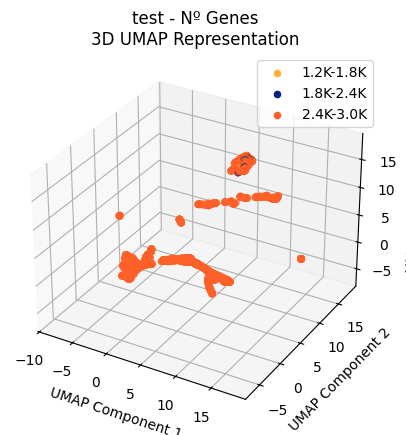

In [124]:
def format_number(n):
    """Format the number to include 'K' for thousands."""
    if n >= 1000:
        return f"{n/1000:.1f}K"
    return str(n)


def get_groups_by_counts(
    data,
    max_genes,
    n_groups=4,
):
    labels = list()
    bins = np.arange(0, max_genes + 1, max_genes / n_groups)
    formatted_bins = [format_number(bin) for bin in bins]

    for n_genes in data:
        for i, bin in enumerate(bins):
            if i == 0:
                label = f"<={formatted_bins[i]}"
            else:
                label = f"{formatted_bins[i-1]}-{formatted_bins[i]}"
            if n_genes <= bin:
                labels.append(label)
                break

    return labels


for data_type in ["train", "test"]:
    if data_type == "train":
        adata = adata_train
        embeddings = umap_embeddings_train
    else:
        adata = adata_test
        embeddings = umap_embeddings_test

    n_genes = (~np.isnan(adata.X)).sum(axis=1)
    labels = get_groups_by_counts(n_groups=5, max_genes=max(n_genes), data=n_genes)
    unique_labels = set(labels)

    label_color_map = {
        k: v
        for k, v in zip(
            unique_labels, [irb_colors[0], irb_colors[4], irb_colors[2], irb_colors[1]]
        )
    }
    colors = [label_color_map.get(label, "grey") for label in labels]

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Scatter plot with colors
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors)

    # Adding legend
    for label in label_color_map:
        ax.scatter([], [], [], c=label_color_map[label], label=label)
    ax.legend()

    # Set labels
    ax.set_xlabel("UMAP Component 1")
    ax.set_ylabel("UMAP Component 2")
    ax.set_zlabel("UMAP Component 3")
    ax.set_title(f"{data_type} - Nº Genes\n3D UMAP Representation")

    # Display the plot
    plt.savefig(
        os.path.join(output_dir, f"{data_type}.umap_3d.n_genes.png"),
        dpi=300,
        bbox_inches="tight",
    )

## Plot Distances/Similarities

In [184]:
# compute cosine similarity matrix, pdist and cdist
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist, cdist

# cosine similarity matrix
c_matrix_test = 1 - cdist(
    scgpt_emb_test, scgpt_emb_test, "cosine"
)  # 1 - cosine distance
c_matrix_train = 1 - cdist(scgpt_emb_train, scgpt_emb_train, "cosine")

# euclidean distance matrix
e_matrix_test = cdist(scgpt_emb_test, scgpt_emb_test, "euclidean")
e_matrix_train = cdist(scgpt_emb_train, scgpt_emb_train, "euclidean")

# pearson correlation matrix
p_matrix_test = 1 - cdist(
    scgpt_emb_test, scgpt_emb_test, "correlation"
)  # 1 - correlation distance
p_matrix_train = 1 - cdist(scgpt_emb_train, scgpt_emb_train, "correlation")

In [183]:
(1 - cdist(scgpt_emb_train[:10], scgpt_emb_train[:10], "cosine"))[0, 0]

0.9999999999999999

In [ ]:
def get_grouped_ps(matrix: np.array, idxs: np.array, labels: List) -> Dict:
    """Get Grouped Pairwise Similarities
    Args:
        matrix (np.array): Pairwise similarity matrix
        idxs (List): List of indexes
        labels (List): List of labels
    Returns:
        grouped_ps (Dict): Dictionary with grouped pairwise similarities
    """
    grouped_ps = dict()
    label_idxs = list(range(len(labels)))
    for i, idx_i in enumerate(label_idxs):
        for idx_j in label_idxs[i:]:
            label_i = labels[idx_i]
            label_j = labels[idx_j]

            if idx_i == idx_j:
                grouped_ps[f"{label_i}-{label_j}"] = get_pairwise_similarities(
                    matrix, idxs[idx_i]
                )
            else:
                grouped_ps[f"{label_i}-{label_j}"] = get_pairwise_similarities(
                    matrix, idxs[idx_i], idxs[idx_j]
                )
    return grouped_ps

Control: 491
Disease: 1384
Control: 292
Disease: 261
Control: 622
Disease: 1495
Control: 984
Disease: 1037
Control: 1401
Disease: 2330
Control: 1492
Disease: 2111
Control: 201
Disease: 259


/tmp/ipykernel_32912/204074235.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 4))


Control: 528
Disease: 527
Control: 106
Disease: 354
Control: 465
Disease: 880
Control: 115
Disease: 43
Control: 3
Disease: 16


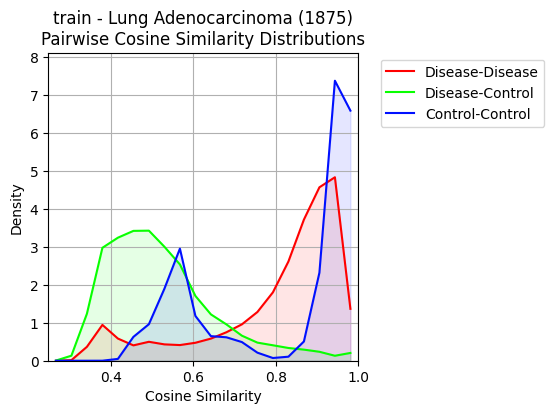

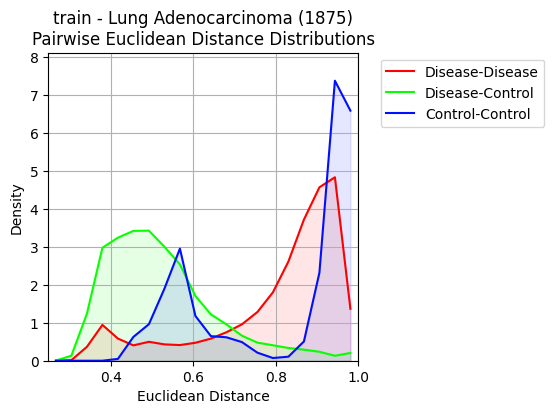

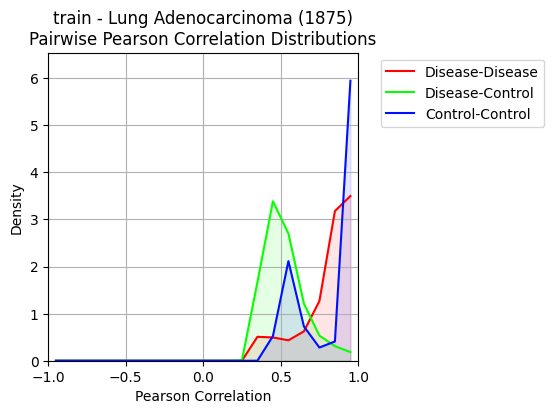

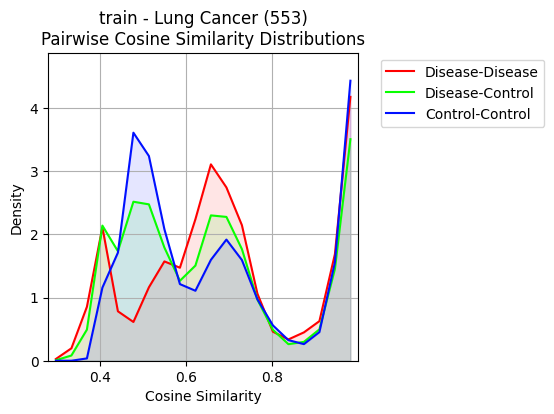

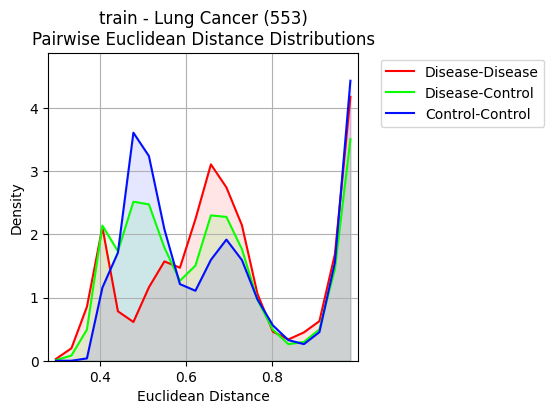

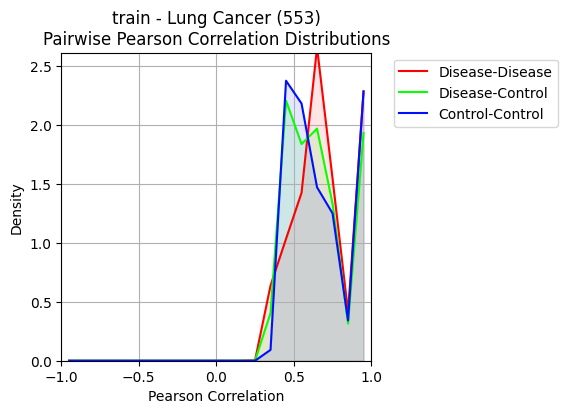

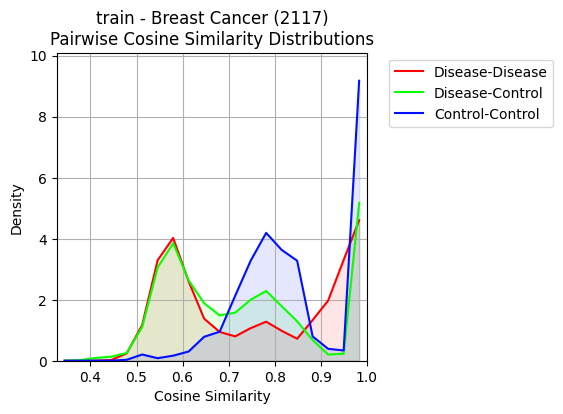

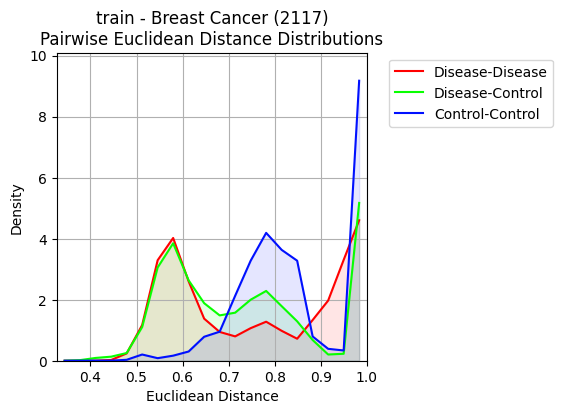

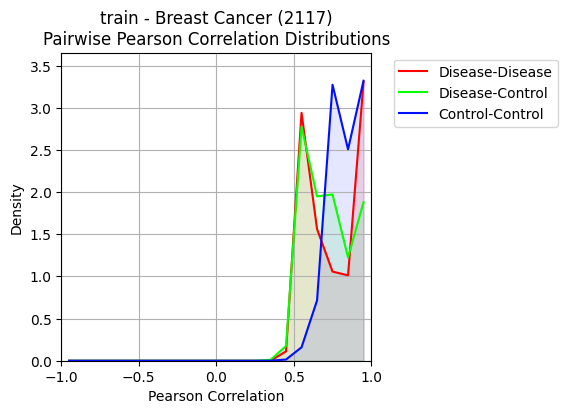

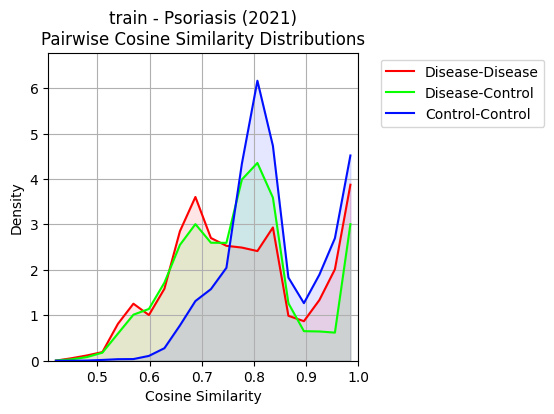

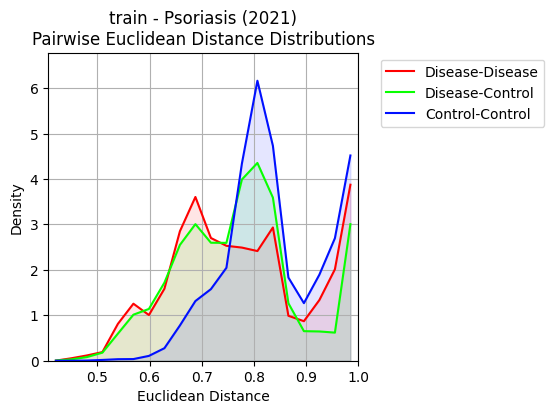

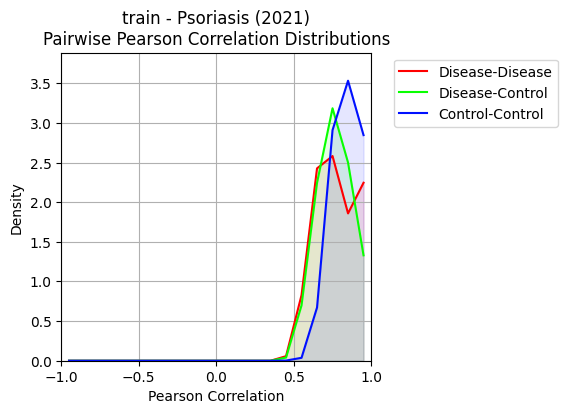

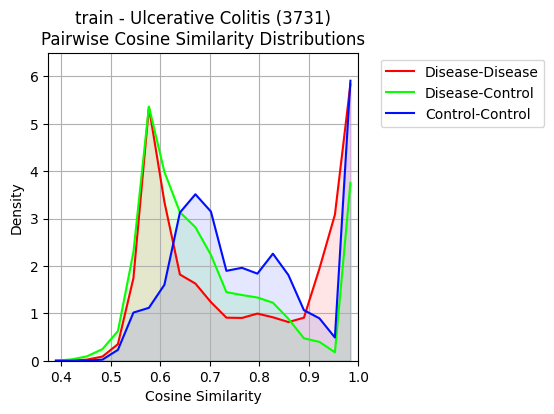

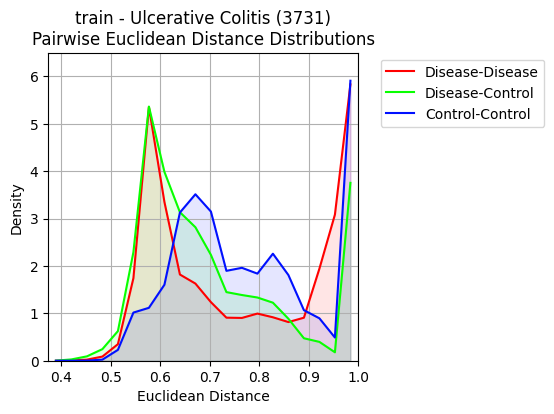

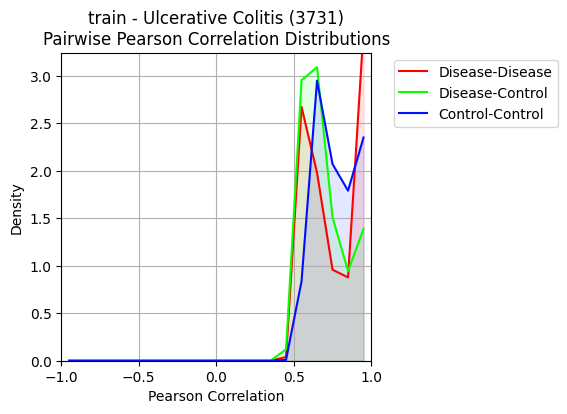

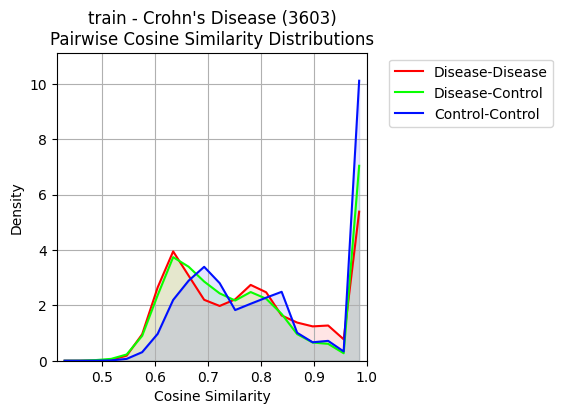

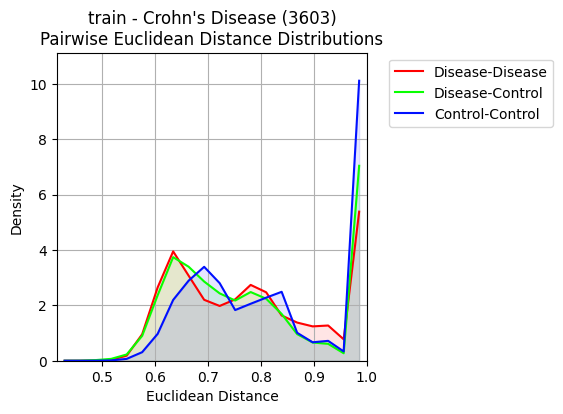

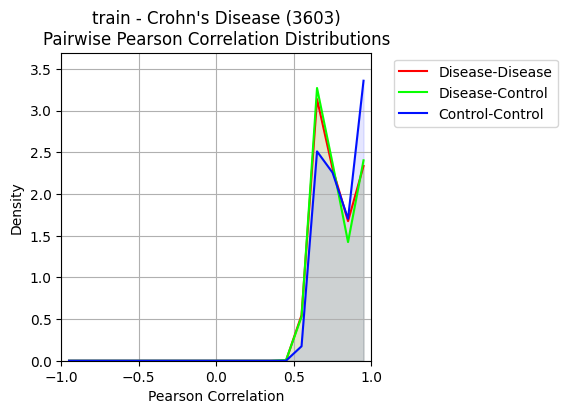

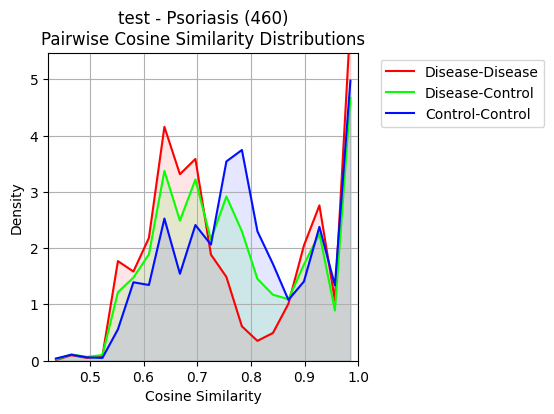

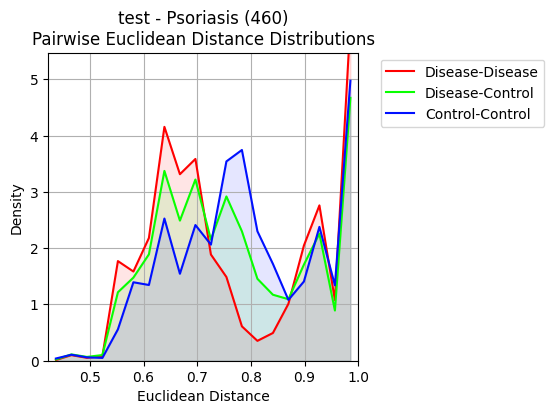

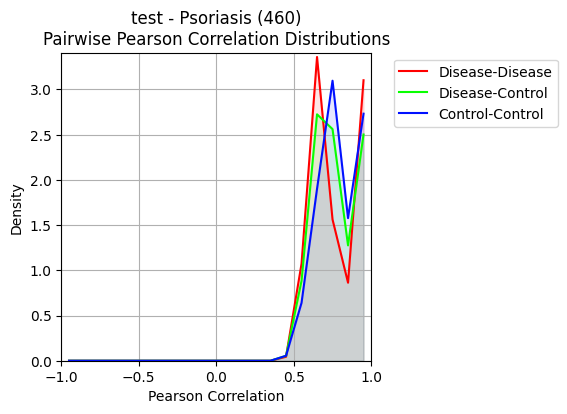

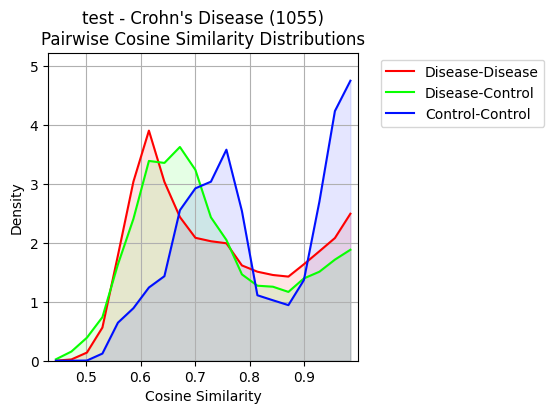

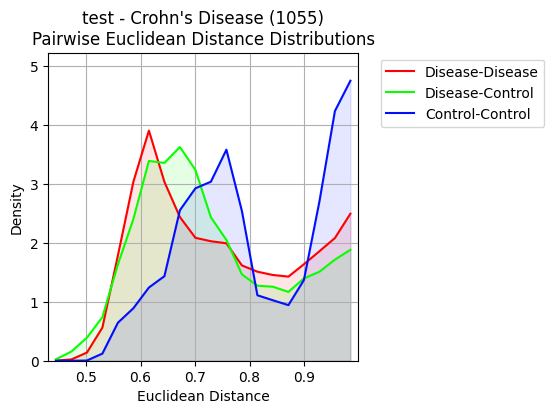

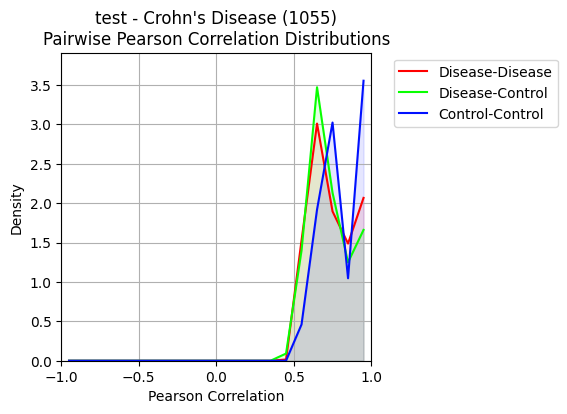

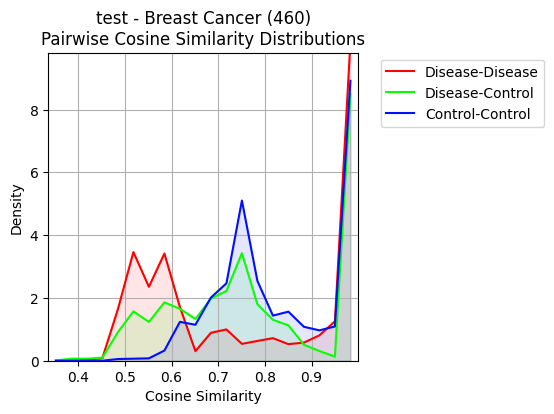

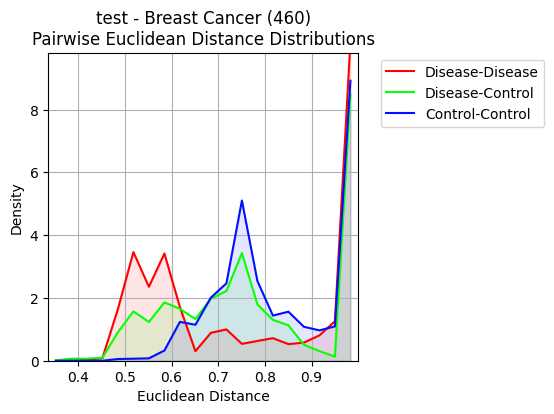

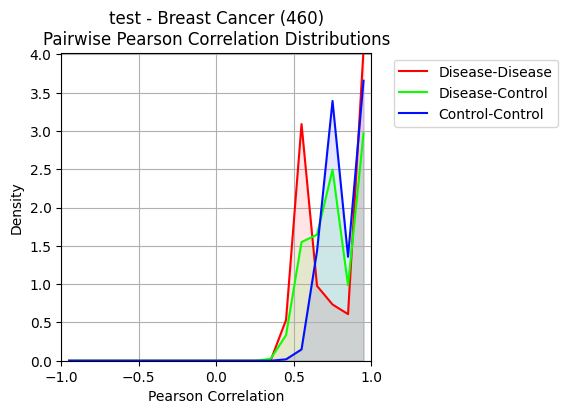

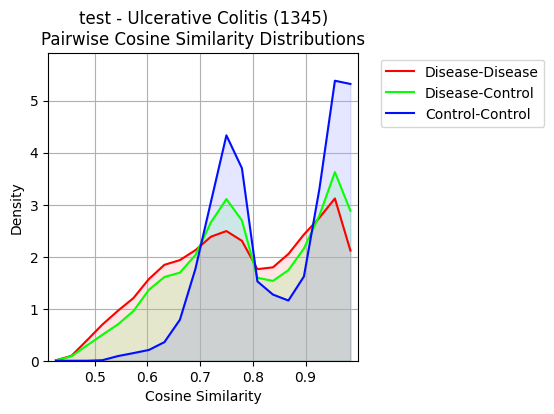

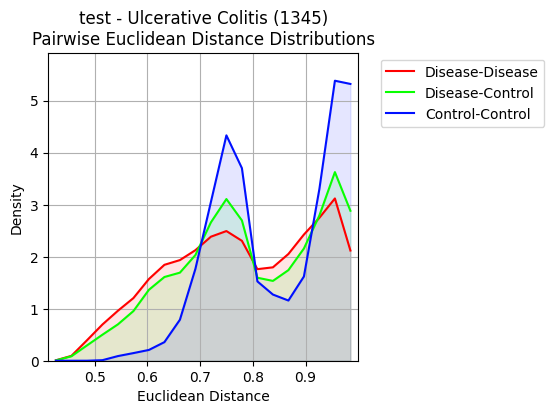

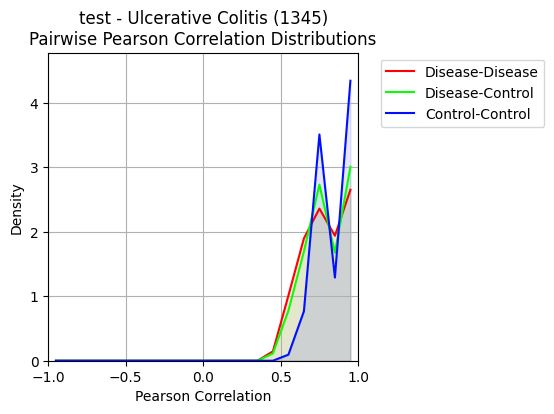

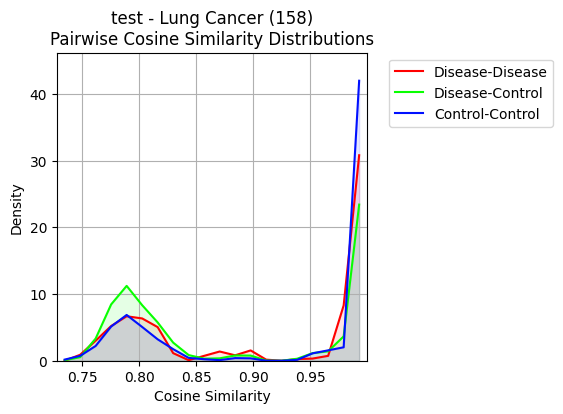

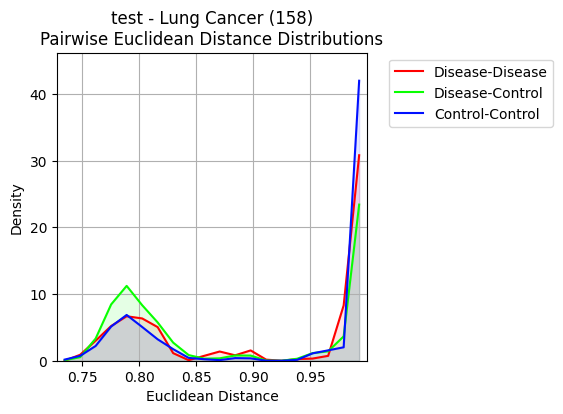

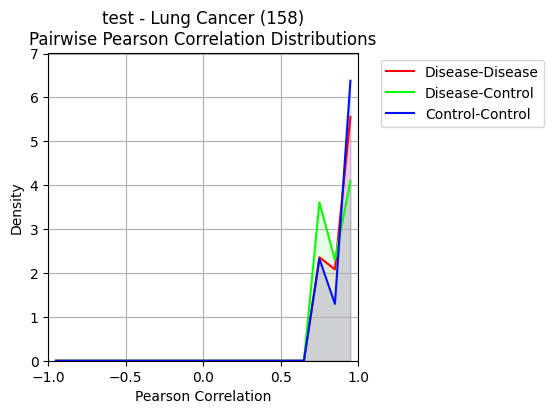

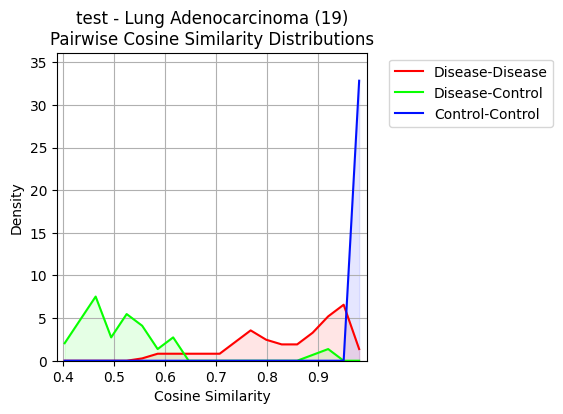

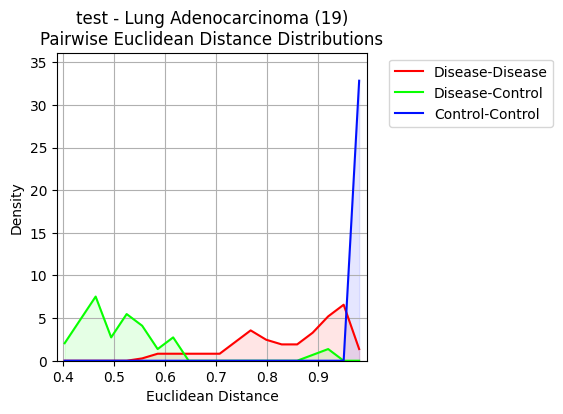

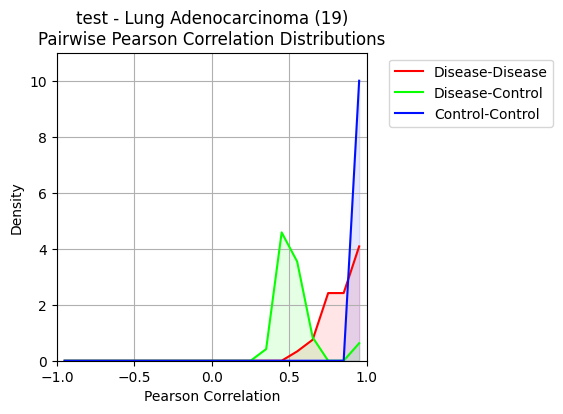

In [193]:
for data_type in ["train", "test"]:

    if data_type == "train":
        adata = adata_train
        c_matrix = c_matrix_train
        e_matrix = e_matrix_train
        p_matrix = p_matrix_train
    else:
        adata = adata_test
        c_matrix = c_matrix_test
        e_matrix = e_matrix_test
        p_matrix = p_matrix_test

    # Compute pairwise similarities for each disease
    for disease_it in adata.obs["disease_study"].unique():

        # get disease & control indexes
        disease_idxs = list()
        control_idxs = list()
        for i, (disease, disease_study) in enumerate(
            zip(adata.obs["disease"].to_list(), adata.obs["disease_study"].to_list())
        ):
            if (disease == disease_it) & (disease_study == disease_it):
                disease_idxs.append(i)
            elif (disease == "Control") & (disease_study == disease_it):
                control_idxs.append(i)

        print(f"Control: {len(control_idxs)}")
        print(f"Disease: {len(disease_idxs)}")
        n_samples = len(disease_idxs) + len(control_idxs)
        # Plot Metrics
        for metric, matrix in zip(
            ["Cosine Similarity", "Euclidean Distance", "Pearson Correlation"],
            [c_matrix, e_matrix, p_matrix],
        ):

            d_ps = get_grouped_ps(
                c_matrix, [disease_idxs, control_idxs], ["Disease", "Control"]
            )

            plot_metrics(
                d_ps.values(),
                d_ps.keys(),
                metric,
                title=f"{data_type} - {disease_it} ({n_samples})",
                output_txt=f"{data_type}_{disease_it.replace(' ','_')}.control_vs_disease",
                save=True,
            )

## MLP Prediction


In [217]:
"""MLP Prediction

Structure:  
    1. Imports, Variables, Functions
    2. Define Splits
    3. Train MLP
    4. Evaluate MLP

"""

# 1. Imports, Variables, Functions
# imports
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

# variables


# functions

# 2. Process Data
logging.info(f"Unfiltered shape: {adata_test.X.shape}")

X_train = adata_train.X
X_test = adata_test.X


# replace nans with 0
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0

# 3. Define Splits


# 4. Train MLP
y_train = adata_train.obs["celltype"].values


# Create and train the model
mlp = MLPClassifier(
    hidden_layer_sizes=(384, 256, 128, 64),  # Four hidden layers with varying sizes
    activation="relu",  # Activation function for the hidden layers
    solver="adam",  # Optimizer
    max_iter=500,  # Maximum number of iterations
    random_state=42,  # For reproducibility
)
mlp.fit(X_train, y_train)


# 4. Evaluate MLP
# Predict
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(adata_test.obs["celltype"], y_pred)

f1_value = f1_score(adata_test.obs["celltype"], y_pred, average="weighted")


print("Predicted labels:", y_pred)
print("Accuracy:", accuracy)
print("F1 Score:", f1_value)

INFO:root:Unfiltered shape: (3497, 2999)


Predicted labels: ['Control' 'Control' 'Control' ... "Crohn's Disease" "Crohn's Disease"
 'Control']
Accuracy: 0.43465827852444955
F1 Score: 0.387375351377088


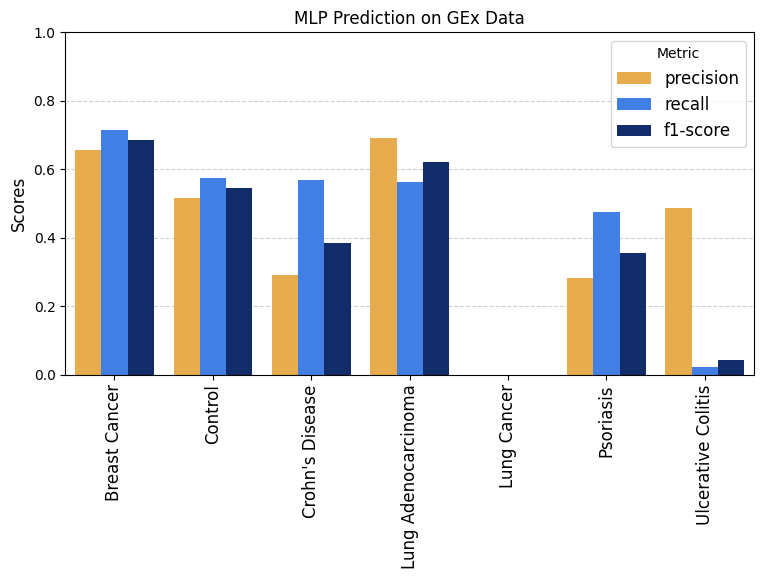

In [218]:
import seaborn as sns

report = classification_report(adata_test.obs["celltype"], y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose()
# Drop non-label rows (accuracy, macro avg, weighted avg)
report_df.drop(index=["accuracy", "macro avg", "weighted avg"], inplace=True)
report_df.drop(columns=["support"], inplace=True)


# Creating the dataframe in a long format for seaborn
df_long = report_df.reset_index().melt(
    id_vars="index", var_name="Metric", value_name="Score"
)
df_long.columns = ["Condition", "Metric", "Score"]

custom_palette = {
    "precision": irb_colors[0],  # Blue
    "recall": irb_colors[3],  # Orange
    "f1-score": irb_colors[4],  # Green
}

# Plotting with seaborn
plt.figure(figsize=(8, 4))
sns.barplot(
    x="Condition",
    y="Score",
    hue="Metric",
    data=df_long,
    palette=custom_palette,
    zorder=2,
)

plt.grid(axis="y", linestyle="--", alpha=0.6, zorder=-3)

# Adding labels and title
plt.xlabel("")
plt.ylabel("Scores", fontsize=12)
plt.title("")

plt.legend(title="Metric", loc="upper right", fontsize=12)
plt.xticks(fontsize=12)

plt.tight_layout()
plt.ylim(0, 1)
plt.xticks(rotation=90)

plt.title("MLP Prediction on GEx Data")

plt.savefig(
    os.path.join(output_dir, "mlp_report.raw_data.png"),
    dpi=300,
    bbox_inches="tight",
)

In [219]:
"""MLP Prediction

Structure:  
    1. Imports, Variables, Functions
    2. Define Splits
    3. Train MLP
    4. Evaluate MLP

"""

# 1. Imports, Variables, Functions
# imports
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# variables


# functions

# 2. Process Data
logging.info(f"Unfiltered shape: {adata_test.X.shape}")

# clean unknown values
# mask_unknown = [
#     False if x.split(";")[2] == "Unknown" else True
#     for x in adata_test.obs["ids"].values
# ]

X_train = scgpt_emb_train
X_test = scgpt_emb_test


# replace nans with 0
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0

# 3. Define Splits

import sklearn
from sklearn.metrics import f1_score

# 4. Train MLP
y_train = adata_train.obs["celltype"].values


# Create and train the model
mlp = MLPClassifier(
    hidden_layer_sizes=(384, 256, 128, 64),  # Four hidden layers with varying sizes
    activation="relu",  # Activation function for the hidden layers
    solver="adam",  # Optimizer
    max_iter=500,  # Maximum number of iterations
    random_state=42,  # For reproducibility
)
mlp.fit(X_train, y_train)


# 4. Evaluate MLP
# Predict
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(adata_test.obs["celltype"], y_pred)

f1_value = f1_score(adata_test.obs["celltype"], y_pred, average="weighted")


print("Predicted labels:", y_pred)
print("Accuracy:", accuracy)
print("F1 Score:", f1_value)

INFO:root:Unfiltered shape: (3497, 2999)


Predicted labels: ['Control' 'Control' 'Control' ... 'Ulcerative Colitis' 'Control'
 'Ulcerative Colitis']
Accuracy: 0.48212753788961965
F1 Score: 0.46451639653461646


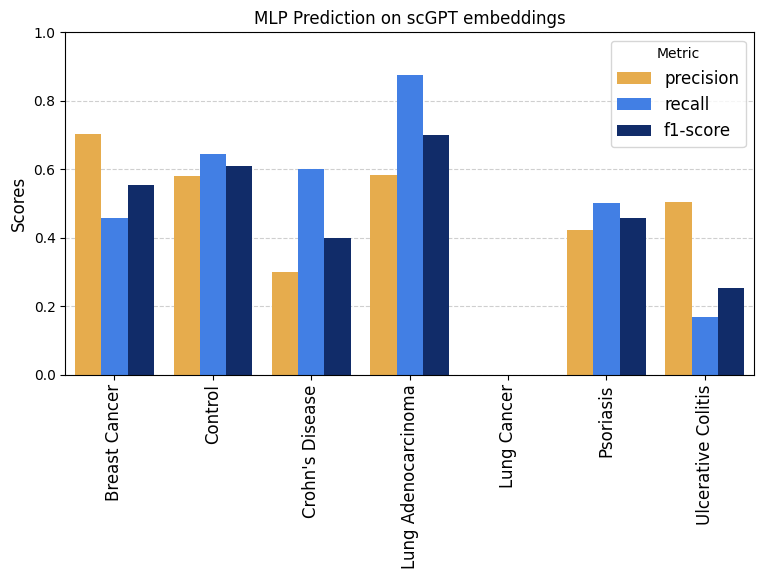

In [220]:
import seaborn as sns

report = classification_report(adata_test.obs["celltype"], y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose()
# Drop non-label rows (accuracy, macro avg, weighted avg)
report_df.drop(index=["accuracy", "macro avg", "weighted avg"], inplace=True)
report_df.drop(columns=["support"], inplace=True)


# Creating the dataframe in a long format for seaborn
df_long = report_df.reset_index().melt(
    id_vars="index", var_name="Metric", value_name="Score"
)
df_long.columns = ["Condition", "Metric", "Score"]

custom_palette = {
    "precision": irb_colors[0],  # Blue
    "recall": irb_colors[3],  # Orange
    "f1-score": irb_colors[4],  # Green
}

# Plotting with seaborn
plt.figure(figsize=(8, 4))
sns.barplot(
    x="Condition",
    y="Score",
    hue="Metric",
    data=df_long,
    palette=custom_palette,
    zorder=2,
)

plt.grid(axis="y", linestyle="--", alpha=0.6, zorder=-3)

# Adding labels and title
plt.xlabel("")
plt.ylabel("Scores", fontsize=12)
plt.title("")

plt.legend(title="Metric", loc="upper right", fontsize=12)
plt.xticks(fontsize=12)

plt.tight_layout()
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.title("MLP Prediction on scGPT embeddings")

plt.savefig(
    os.path.join(output_dir, "mlp_report.scgpt.png"),
    dpi=300,
    bbox_inches="tight",
)

/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


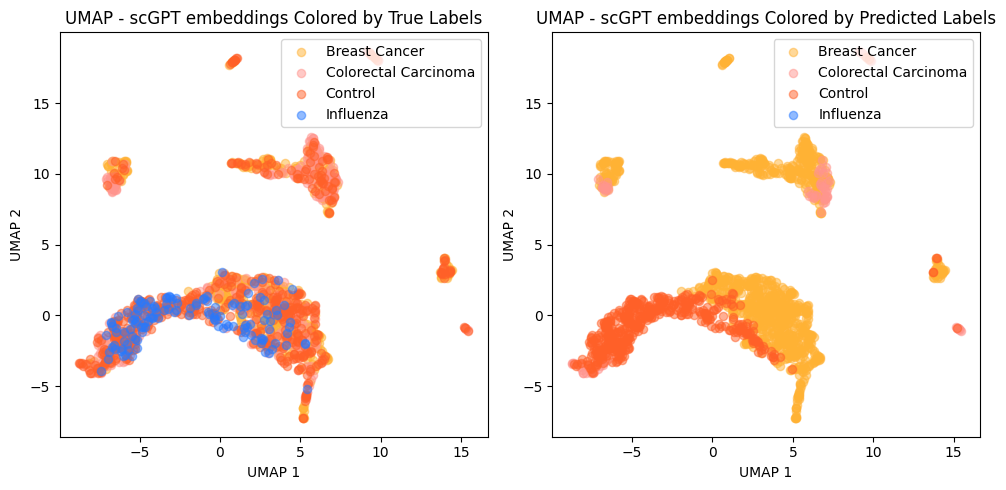

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your labels and corresponding colors
labels = np.unique(y_test)

# Create UMAP embeddings
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
X_test_umap = reducer.fit_transform(X_test)


color_map = {label: color for label, color in zip(labels, irb_colors)}

# Plotting the UMAP results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# UMAP colored by true labels
for label in labels:
    idx = y_test == label
    axes[0].scatter(
        X_test_umap[idx, 0],
        X_test_umap[idx, 1],
        c=color_map[label],
        label=label,
        s=35,
        alpha=0.5,
    )
axes[0].set_title("UMAP - scGPT embeddings Colored by True Labels")
axes[0].legend()
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")

# UMAP colored by predicted labels
for label in labels:
    idx = y_pred == label
    axes[1].scatter(
        X_test_umap[idx, 0],
        X_test_umap[idx, 1],
        c=color_map[label],
        label=label,
        s=35,
        alpha=0.5,
    )
axes[1].set_title("UMAP - scGPT embeddings Colored by Predicted Labels")
axes[1].legend()
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")º

plt.tight_layout()
plt.savefig("outputs/umap_raw_data_pred_labels.scgpt.png", dpi=300, bbox_inches="tight")

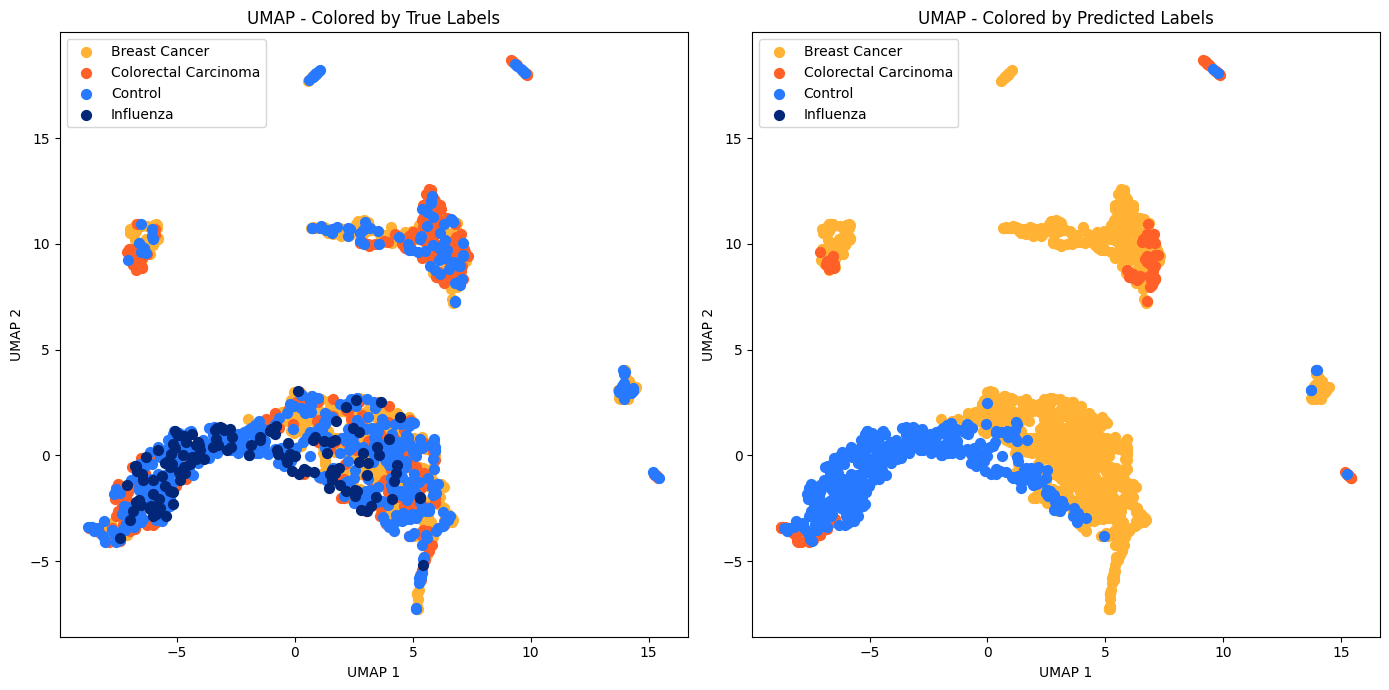

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your labels and corresponding colors
labels = np.unique(y_test)


color_map = {
    label: color for label, color in zip(labels, irb_colors[:1] + irb_colors[2:])
}

# Plotting the UMAP results
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# UMAP colored by true labels
for label in labels:
    idx = y_test == label
    axes[0].scatter(
        X_test_umap[idx, 0], X_test_umap[idx, 1], c=color_map[label], label=label, s=50
    )
axes[0].set_title("UMAP - Colored by True Labels")
axes[0].legend()
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")

# UMAP colored by predicted labels
for label in labels:
    idx = y_pred == label
    axes[1].scatter(
        X_test_umap[idx, 0], X_test_umap[idx, 1], c=color_map[label], label=label, s=50
    )
axes[1].set_title("UMAP - Colored by Predicted Labels")
axes[1].legend()
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

plt.tight_layout()
plt.savefig(
    "outputs/umap.scgpt_embed.pred_labels.raw.png", dpi=300, bbox_inches="tight"
)

In [44]:
group_non_nan_counts

array([[2.],
       [3.]])